In [1]:
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmWarning)
from tqdm.auto import tqdm  # will not emit the IProgress warning now

In [2]:
from utils import base_configs, deps, tr_va_te_split
from utils.helpers import rw_csv_helpers

In [3]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
CONFIGS = base_configs.get_base_configs()
# path to your global SHAP file

#SWITCH THE FOLLOWING ACCORDINGLY
CONFIGS["RUN_TS"] = "20251118_101434"

In [5]:
import os
import pandas as pd

# Model ids and human-readable names
model_info = {
    "lr": "Logistic Regression",
    "rf": "Random Forest",
    "mlp": "Multi Layer Perceptron",
    "tabnet": "TabNet",
    "xgb": "XGBoost",
    "xlstm": "XLSTM",
}

run_ts = CONFIGS["RUN_TS"]
base_dir = f"op/tr_va_te_metric_shap_{run_ts}"

# ---------- 1. Read global SHAP file ----------
global_path = os.path.join(base_dir, f"global_shap_{run_ts}.csv")
global_df = pd.read_csv(global_path)

# Ensure feature is index if present
if "feature" in global_df.columns:
    global_df = global_df.set_index("feature")

# ---------- 2. Read model strengths / weights ----------
strength_path = os.path.join(base_dir, "models_pred_strength.csv")
strength_df = pd.read_csv(strength_path)

# Index by ModelName so we can look up ModelWeight by key (lr, rf, ...)
strength_df = strength_df.set_index("ModelName")

# ---------- 3. For each model, create WSA_{ModelFullName}_shap ----------
for key, full_name in model_info.items():
    shap_norm_col = f"{key}_shap_norm"

    if shap_norm_col not in global_df.columns:
        print(f"[WARN] Column {shap_norm_col} not found in global_shap file; skipping {key}")
        continue

    if key not in strength_df.index:
        print(f"[WARN] Model {key} not found in models_pred_strength; skipping")
        continue

    model_weight = strength_df.loc[key, "ModelWeight"]

    # New column name as requested
    wsa_col = f"WSA_{key}_shap"

    # Weighted normalized global SHAP for this model
    global_df[wsa_col] = global_df[shap_norm_col] * model_weight

# ---------- 4. Save updated global_shap file (optional overwrite) ----------
global_out_path = os.path.join(base_dir, f"global_shap_{run_ts}_with_WSA.csv")
global_df.to_csv(global_out_path)

print(f"Saved updated global SHAP with WSA columns to: {global_out_path}")


[WARN] Column tabnet_shap_norm not found in global_shap file; skipping tabnet
Saved updated global SHAP with WSA columns to: op/tr_va_te_metric_shap_20251118_101434/global_shap_20251118_101434_with_WSA.csv


#### ADD "TabNet Importance" and "Weighted TabNet Importance" in a columns

In [6]:
import os
import pandas as pd

# Model ids and human-readable names
model_info = {
    "lr": "Logistic Regression",
    "rf": "Random Forest",
    "mlp": "Multi Layer Perceptron",
    "tabnet": "TabNet",
    "xgb": "XGBoost",
    "xlstm": "XLSTM",
}

run_ts = CONFIGS["RUN_TS"]
base_dir = f"op/tr_va_te_metric_shap_{run_ts}"

# ---------- 1. Read global SHAP file ----------
global_path = os.path.join(base_dir, f"global_shap_{run_ts}.csv")
global_df = pd.read_csv(global_path)

# Ensure feature is index if present
if "feature" in global_df.columns:
    global_df = global_df.set_index("feature")

# ---------- 2. Read model strengths / weights ----------
strength_path = os.path.join(base_dir, "models_pred_strength.csv")
strength_df = pd.read_csv(strength_path)
strength_df = strength_df.set_index("ModelName")  # index by lr, rf, ...

# ---------- 3. For each model, create Weighted_{key}_shap ----------
for key, full_name in model_info.items():
    shap_norm_col = f"{key}_shap_norm"

    if shap_norm_col not in global_df.columns:
        print(f"[WARN] Column {shap_norm_col} not found in global_shap file; skipping {key}")
        continue

    if key not in strength_df.index:
        print(f"[WARN] Model {key} not found in models_pred_strength; skipping")
        continue

    model_weight = strength_df.loc[key, "ModelWeight"]
    weighted_col = f"Weighted_{key}_shap"

    # Weighted normalized global SHAP for this model
    global_df[weighted_col] = global_df[shap_norm_col] * model_weight

# ---------- 4. Read TabNet feature importances and normalize ----------
tabnet_feat_path = os.path.join(base_dir, "tabnet", "tabnet_features.csv")
tabnet_df = pd.read_csv(tabnet_feat_path)

# Keep only feature and importance, index by feature
tabnet_df = tabnet_df[["feature", "importance"]].set_index("feature")

# L1-normalize importance to get tabnet_imp_norm
den = tabnet_df["importance"].sum()
if den != 0:
    tabnet_df["tabnet_imp_norm"] = tabnet_df["importance"] / den
else:
    tabnet_df["tabnet_imp_norm"] = 0.0

# Join tabnet_imp_norm into global_df on feature
global_df = global_df.join(tabnet_df["tabnet_imp_norm"], how="left")

# ---------- 5. Weighted_tabnet_imp = tabnet_imp_norm * ModelWeight(tabnet) ----------
if "tabnet_imp_norm" in global_df.columns and "tabnet" in strength_df.index:
    tabnet_weight = strength_df.loc["tabnet", "ModelWeight"]
    global_df["Weighted_tabnet_imp"] = global_df["tabnet_imp_norm"] * tabnet_weight
else:
    print("[WARN] Could not compute Weighted_tabnet_imp (missing tabnet_imp_norm or tabnet weight).")

# ---------- 6. Save updated global_shap file ----------
global_out_path = os.path.join(base_dir, f"global_shap_{run_ts}_with_weightedSHAP_InclTabNetImp.csv")
global_df.to_csv(global_out_path)

print(f"Saved updated global SHAP with Weighted_* columns and tabnet_imp_norm / Weighted_tabnet_imp to: {global_out_path}")


[WARN] Column tabnet_shap_norm not found in global_shap file; skipping tabnet
Saved updated global SHAP with Weighted_* columns and tabnet_imp_norm / Weighted_tabnet_imp to: op/tr_va_te_metric_shap_20251118_101434/global_shap_20251118_101434_with_weightedSHAP_InclTabNetImp.csv


In [7]:
import os
import pandas as pd

# Model ids and human-readable names
model_info = {
    "lr": "Logistic Regression",
    "rf": "Random Forest",
    "mlp": "Multi Layer Perceptron",
    "tabnet": "TabNet",
    "xgb": "XGBoost",
    "xlstm": "XLSTM",
}

run_ts = CONFIGS["RUN_TS"]
base_dir = f"op/tr_va_te_metric_shap_{run_ts}"

# ---------- 1. Read global SHAP file ----------
global_path = os.path.join(base_dir, f"global_shap_{run_ts}.csv")
global_df = pd.read_csv(global_path)

# Ensure feature is index if present
if "feature" in global_df.columns:
    global_df = global_df.set_index("feature")

# ---------- 2. Read model strengths / weights ----------
strength_path = os.path.join(base_dir, "models_pred_strength.csv")
strength_df = pd.read_csv(strength_path)
strength_df = strength_df.set_index("ModelName")  # index: lr, rf, ...

# ---------- 3. For each model, create Weighted_{key}_shap ----------
for key, full_name in model_info.items():
    shap_norm_col = f"{key}_shap_norm"

    if shap_norm_col not in global_df.columns:
        print(f"[WARN] Column {shap_norm_col} not found in global_shap file; skipping {key}")
        continue

    if key not in strength_df.index:
        print(f"[WARN] Model {key} not found in models_pred_strength; skipping")
        continue

    model_weight = strength_df.loc[key, "ModelWeight"]
    weighted_col = f"Weighted_{key}_shap"

    # Weighted normalized global SHAP for this model
    global_df[weighted_col] = global_df[shap_norm_col] * model_weight

# ---------- 4. Read TabNet feature importances and normalize ----------
tabnet_feat_path = os.path.join(base_dir, "tabnet", "tabnet_features.csv")
tabnet_df = pd.read_csv(tabnet_feat_path)

# Keep only feature and importance, index by feature
tabnet_df = tabnet_df[["feature", "importance"]].set_index("feature")

# L1-normalize importance to get tabnet_imp_norm
den = tabnet_df["importance"].sum()
if den != 0:
    tabnet_df["tabnet_imp_norm"] = tabnet_df["importance"] / den
else:
    tabnet_df["tabnet_imp_norm"] = 0.0

# Join tabnet_imp_norm into global_df on feature
global_df = global_df.join(tabnet_df["tabnet_imp_norm"], how="left")

# ---------- 5. Weighted_tabnet_imp = tabnet_imp_norm * ModelWeight(tabnet) ----------
if "tabnet_imp_norm" in global_df.columns and "tabnet" in strength_df.index:
    tabnet_weight = strength_df.loc["tabnet", "ModelWeight"]
    global_df["Weighted_tabnet_imp"] = global_df["tabnet_imp_norm"] * tabnet_weight
else:
    print("[WARN] Could not compute Weighted_tabnet_imp (missing tabnet_imp_norm or tabnet weight).")

# ---------- 6. WSA_SHAP_IMP: average of 6 weighted columns ----------
# Columns to use (6 columns total, as specified)
wsa_cols = [
    "Weighted_lr_shap",
    "Weighted_rf_shap",
    "Weighted_mlp_shap",
    "Weighted_xgb_shap",
    "Weighted_xlstm_shap",
    "Weighted_tabnet_imp",
]

missing = [c for c in wsa_cols if c not in global_df.columns]
if missing:
    print(f"[WARN] Some WSA columns missing, cannot fully compute WSA_SHAP_IMP: {missing}")

# Compute average across the available columns among the 6
present_cols = [c for c in wsa_cols if c in global_df.columns]
if present_cols:
    # Explicitly divide by 6 (number of intended columns), as requested
    global_df["WSA_SHAP_IMP"] = global_df[present_cols].sum(axis=1)
else:
    global_df["WSA_SHAP_IMP"] = float("nan")

# ---------- 7. Save updated global_shap file ----------
global_out_path = os.path.join(base_dir, f"global_shap_{run_ts}_with_weightedSHAP_InclTabNetImp_WSA.csv")
global_df.to_csv(global_out_path)

print(f"Saved updated global SHAP with Weighted_* columns, tabnet_imp_norm, "
      f"Weighted_tabnet_imp, and WSA_SHAP_IMP to: {global_out_path}")


[WARN] Column tabnet_shap_norm not found in global_shap file; skipping tabnet
Saved updated global SHAP with Weighted_* columns, tabnet_imp_norm, Weighted_tabnet_imp, and WSA_SHAP_IMP to: op/tr_va_te_metric_shap_20251118_101434/global_shap_20251118_101434_with_weightedSHAP_InclTabNetImp_WSA.csv


## PLOT THE WEIGHT OF EACH MODEL

/tmp/ipykernel_24602/1028847051.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(1, n))


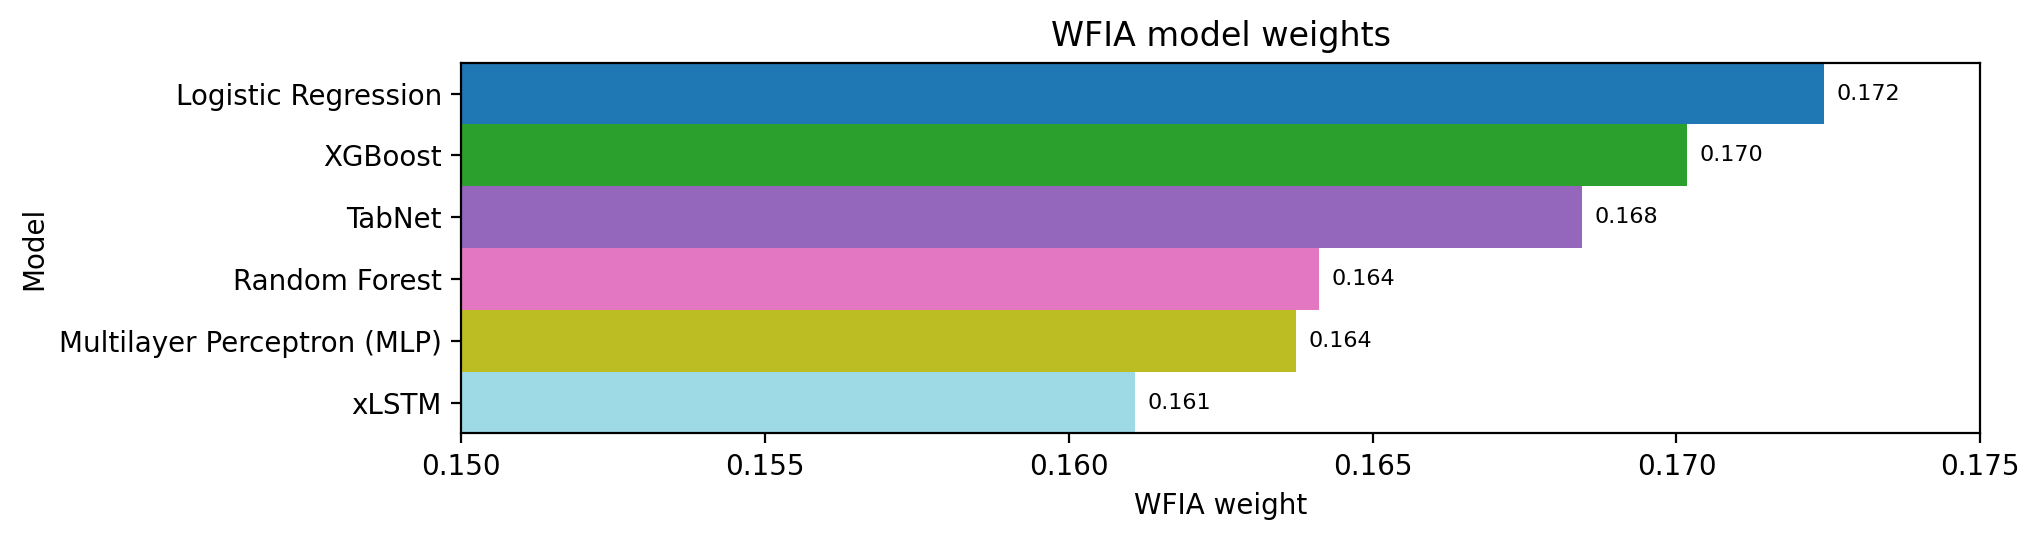

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Load ------------------
path = "op/all_test_report_with_scores_weights.csv"
df = pd.read_csv(path)

# ------------------ Columns ------------------
weight_col = next(c for c in df.columns if c.lower() == "wfia_weight")
model_col = next(
    (c for c in df.columns if c.lower() in {"model", "model_name", "modelname", "algorithm", "estimator"}),
    None
)
if model_col is None:
    model_col = next(c for c in df.columns if "model" in c.lower())

# ------------------ Aggregate ------------------
plot_df = (
    df[[model_col, weight_col]]
    .dropna()
    .groupby(model_col, as_index=False)[weight_col]
    .mean()
    .sort_values(weight_col, ascending=False)
    .reset_index(drop=True)
)

# ------------------ Full model names ------------------
name_map = {
    "LR": "Logistic Regression",
    "LOGISTIC REGRESSION": "Logistic Regression",
    "RF": "Random Forest",
    "RANDOM FOREST": "Random Forest",
    "XGB": "XGBoost",
    "XGBOOST": "XGBoost",
    "TABNET": "TabNet",
    "MLP": "Multilayer Perceptron (MLP)",
    "MULTILAYER PERCEPTRON": "Multilayer Perceptron (MLP)",
    "XLSTM": "xLSTM",
    "X-LSTM": "xLSTM",
}
plot_df["Model_full"] = plot_df[model_col].astype(str).str.strip().apply(
    lambda s: name_map.get(s.upper(), s)
)

# ------------------ Axis range ------------------
xmin, xmax = 0.150, 0.175
xticks = np.linspace(xmin, xmax, 6)

# ------------------ VISUALLY thin bars (pixel-controlled) ------------------
n = len(plot_df)

# Bar thickness in data units + no gaps
bar_h = 0.25
y_step = bar_h
y = np.arange(n) * y_step

# Control "thinness" in pixels:
# smaller px_per_bar => thinner bars; keep some minimum for readability
px_per_bar = 18  # try 14 for even thinner
dpi = 200        # higher DPI makes thinness clearer

fig_h_in = (n * px_per_bar) / dpi
fig_h_in = max(fig_h_in, 2.5)  # safety minimum

fig, ax = plt.subplots(figsize=(10, fig_h_in), dpi=dpi)

cmap = plt.cm.get_cmap("tab20", max(1, n))
colors = [cmap(i) for i in range(n)]

bars = ax.barh(y, plot_df[weight_col].values, height=bar_h, color=colors)

ax.set_yticks(y)
ax.set_yticklabels(plot_df["Model_full"].tolist())

ax.set_xlim(xmin, xmax)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{t:.3f}" for t in xticks])

ax.set_xlabel("WFIA weight")
ax.set_ylabel("Model")
ax.set_title("WFIA model weights")

ax.invert_yaxis()

# No top/bottom whitespace: tight to bar edges
top_edge = y[-1] + bar_h / 2
bottom_edge = -bar_h / 2
ax.set_ylim(top_edge, bottom_edge)

# No outer padding
ax.margins(x=0, y=0)
plt.tight_layout(pad=0)

# Value labels (kept inside axis)
for yi, w in zip(y, plot_df[weight_col].values):
    x_text = min(w + 0.0002, xmax - 0.0001)
    ax.text(x_text, yi, f"{w:.3f}", va="center", ha="left", fontsize=8)

plt.show()

# Optional save (tight)
fig.savefig("op/fin_op/wfia_weights_thin_nogaps.png", bbox_inches="tight", pad_inches=0, dpi=dpi)


## PLOT IMPORTANCE OF EACH MODEL